<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/BarcodeDeskew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Subí una imagen (png/jpg)…


Saving IMG_9186.jpeg to IMG_9186.jpeg
Ángulo estimado (para hacer barras verticales): 84.49°


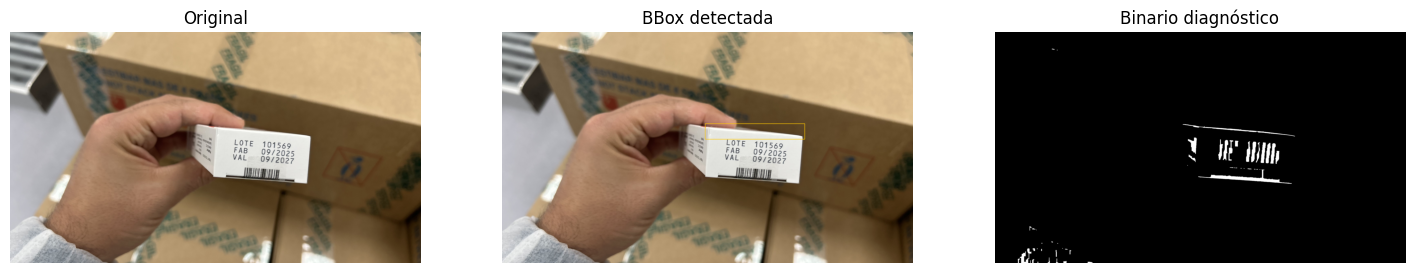

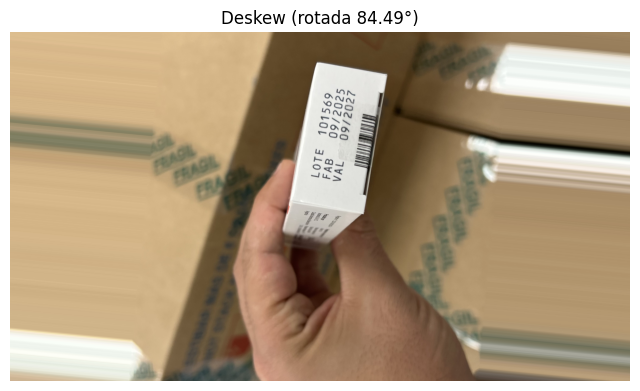

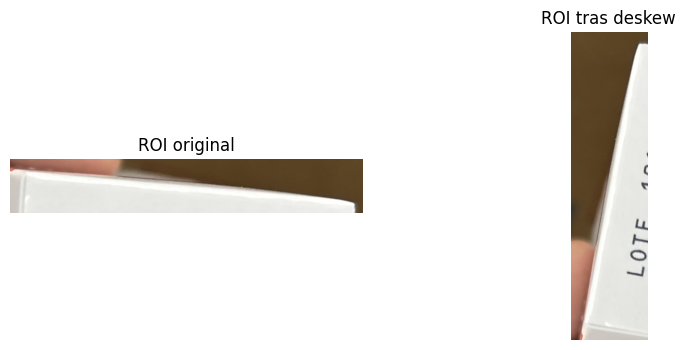

In [4]:
# ==========================
# 1) Instalación e imports
# ==========================
!pip -q install opencv-python numpy matplotlib >/dev/null

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import math

def show_row(images, titles=None, cmap=None, size=(14,5)):
    n = len(images)
    plt.figure(figsize=(size[0], size[1]))
    for i, img in enumerate(images, 1):
        plt.subplot(1, n, i)
        if img is None:
            plt.title((titles[i-1] if titles else "") + "\n(None)")
            plt.axis("off"); continue
        if img.ndim == 2:
            plt.imshow(img, cmap=cmap or "gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles: plt.title(titles[i-1])
        plt.axis("off")
    plt.show()

# ============================================
# 2) Subir imagen
# ============================================
print("Subí una imagen (png/jpg)…")
up = files.upload()
assert len(up) > 0, "No se subió imagen."
name, content = next(iter(up.items()))
data = np.frombuffer(content, dtype=np.uint8)
img_bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
assert img_bgr is not None, "No se pudo leer la imagen."

# =========================================================
# 3) Detectar ROI del código de barras (morfología OpenCV)
#    Se prueban dos orientaciones y se elige la mejor
# =========================================================
def morph_best_bbox(gray):
    def eval_dir(dx, dy, kx, ky):
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=dx, dy=dy, ksize=3)
        grad = cv2.convertScaleAbs(grad)
        grad = cv2.normalize(grad, None, 0, 255, cv2.NORM_MINMAX)
        _, th = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kx, ky))
        closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
        closed = cv2.erode(closed, None, iterations=2)
        closed = cv2.dilate(closed, None, iterations=2)
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            return None, None
        best, best_score = None, -1
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            area = w*h
            aspect = max(w, h) / (min(w, h) + 1e-6)
            score = area * (aspect if aspect > 1.5 else 0.3)  # favorece bandas alargadas
            if score > best_score:
                best_score, best = score, (x, y, w, h, closed)
        return best, best_score

    bx1, sc1 = eval_dir(1, 0, 25, 7)   # barras verticales → gradiente X
    bx2, sc2 = eval_dir(0, 1, 7, 25)   # barras horizontales → gradiente Y

    if bx1 is None and bx2 is None:
        return None, None
    if sc2 is None or (sc1 is not None and sc1 >= sc2):
        x, y, w, h, binimg = bx1
    else:
        x, y, w, h, binimg = bx2
    return (x, y, w, h), binimg

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (3,3), 0)
bbox, bin_diag = morph_best_bbox(gray_blur)

if bbox is None:
    print("No se detectó ROI de código de barras. Mostrando solo la original.")
    show_row([img_bgr], ["Original"])
else:
    x, y, w, h = bbox
    pad = int(0.03 * max(w, h))
    x2 = max(x - pad, 0); y2 = max(y - pad, 0)
    x3 = min(x + w + pad, img_bgr.shape[1]); y3 = min(y + h + pad, img_bgr.shape[0])
    roi = img_bgr[y2:y3, x2:x3].copy()

    vis_bbox = img_bgr.copy()
    cv2.rectangle(vis_bbox, (x2, y2), (x3, y3), (0, 200, 255), 3)

    # ======================================================
    # 4) Estimar ángulo dominante de las barras con PCA
    #    sobre bordes (Canny) dentro de la ROI
    # ======================================================
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(roi_gray, 50, 150, apertureSize=3, L2gradient=True)

    ys, xs = np.where(edges > 0)
    if len(xs) < 50:
        print("Muy pocos bordes para estimar ángulo; no se rota.")
        rotated = img_bgr
        angle_deg = 0.0
    else:
        pts = np.column_stack((xs.astype(np.float32), ys.astype(np.float32)))
        mean, eigenvectors = cv2.PCACompute(pts, mean=None)
        # Vector principal (dirección de mayor varianza)
        vx, vy = eigenvectors[0]
        theta = math.degrees(math.atan2(vy, vx))  # 0° = eje X; 90° = vertical
        # Queremos que esta dirección quede VERTICAL (90°)
        angle_deg = 90.0 - theta
        # Normalizar a [-90, 90] para evitar rotaciones excesivas
        if angle_deg > 90: angle_deg -= 180
        if angle_deg < -90: angle_deg += 180

        # Rotar imagen completa
        (H, W) = img_bgr.shape[:2]
        center = (W//2, H//2)
        M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
        rotated = cv2.warpAffine(img_bgr, M, (W, H),
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_REPLICATE)

    print(f"Ángulo estimado (para hacer barras verticales): {angle_deg:.2f}°")

    # ==========================
    # 5) Mostrar resultados
    # ==========================
    show_row(
        [img_bgr, vis_bbox, bin_diag],
        ["Original", "BBox detectada", "Binario diagnóstico"],
        cmap="gray", size=(18,5)
    )
    show_row([rotated], [f"Deskew (rotada {angle_deg:.2f}°)"], size=(8,5))

    # Recortar nuevamente la ROI sobre la imagen rotada (opcional, para ver mejora)
    (H, W) = rotated.shape[:2]
    # Transformar las esquinas del bbox original con la matriz M para un recorte aproximado
    def warp_pts(M, pts):
        pts = np.array(pts, dtype=np.float32).reshape(-1, 1, 2)
        res = cv2.transform(pts, M)
        return res.reshape(-1, 2)

    if 'M' in locals():
        corners = [(x2, y2), (x3, y2), (x3, y3), (x2, y3)]
        wc = warp_pts(M, corners)
        x_min = max(int(np.min(wc[:,0])), 0); y_min = max(int(np.min(wc[:,1])), 0)
        x_max = min(int(np.max(wc[:,0])), W); y_max = min(int(np.max(wc[:,1])), H)
        roi_rot = rotated[y_min:y_max, x_min:x_max].copy() if x_max>x_min and y_max>y_min else None
        show_row([roi, roi_rot], ["ROI original", "ROI tras deskew"], size=(10,4))
